In [1]:
import pandas as pd
import numpy as np

import prophet

import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

color_pal = sn.color_palette()
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    #calculate MAPE given y_true, y_pred
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [3]:
energy = pd.read_csv("C:\\Users\\USER\\Desktop\\New data\\PJME_hourly.csv",
                index_col=[0],
                parse_dates=[0])
energy.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'PJME MegaWatts'}, xlabel='Datetime'>

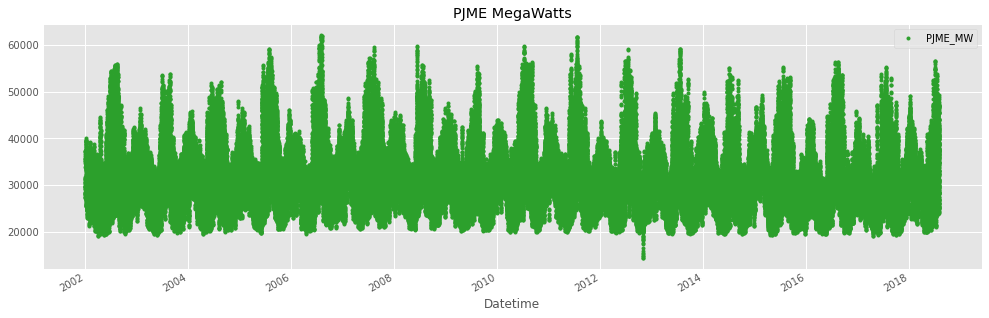

In [5]:
energy.plot(style='.', figsize=(15,5), color=color_pal[2], title='PJME MegaWatts')

# Time Series Features

In [47]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                           ordered=True)

In [48]:
energy = energy.query('PJME_MW > 19000').copy()
#Figures below 19000 are considered to be outliers.

In [49]:
df=energy.copy()


In [43]:
df=energy.copy()   #This ensures that we're editing a copy of the dataframe
df['Date']=df.index
df['Hour'] = df['Date'].dt.hour 
df['Dayofweek']=df['Date'].dt.dayofweek
df['Weekday']=df['Date'].dt.day_name()
df['Weekday']=df['Weekday'].astype(cat_type)
df['Quarter']= df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Dayofyear'] =  df['Date'].dt.dayofyear
df['Dayofmonth'] =df['Date'].dt.day
df['Weekofyear'] = df['Date'].dt.weekofyear
df['Date_offset']=(df.Date.dt.month*100 + df.Date.dt.day-320)%1300
df['Season'] = pd.cut(df['Date_offset'], [0,300,602,900,1300], 
                      labels=['Spring', 'Summer', 'Fall', 'Winter'])

X = df[['Hour', 'Dayofweek','Quarter', 'Month', 'Year', 'Dayofyear',
       'Dayofmonth', 'Weekofyear', 'Weekday', 'Season']]

In [50]:
def create_features(df, label=None):    #Create time series features based on time series index
    df=energy.copy()   #This ensures that we're editing a copy of the dataframe
    df['Date']=df.index
    df['Hour'] = df['Date'].dt.hour 
    df['Dayofweek']=df['Date'].dt.dayofweek
    df['Weekday']=df['Date'].dt.day_name()
    df['Weekday']=df['Weekday'].astype(cat_type)
    df['Quarter']= df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Dayofyear'] =  df['Date'].dt.dayofyear
    df['Dayofmonth'] =df['Date'].dt.day
    df['Weekofyear'] = df['Date'].dt.weekofyear
    df['Date_offset']=(df.Date.dt.month*100 + df.Date.dt.day-320)%1300
    df['Season'] = pd.cut(df['Date_offset'], [0,300,602,900,1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['Hour', 'Dayofweek','Quarter', 'Month', 'Year', 'Dayofyear',
           'Dayofmonth', 'Weekofyear', 'Weekday', 'Season']]
    
    if label:
        y=df[label]
        return X, y
    return X
X, y = create_features(df, label='PJME_MW')
features_and_target = pd.concat([X,y], axis=1)

In [51]:
features_and_target

,Hour,Dayofweek,Quarter,Month,Year,Dayofyear,Dayofmonth,Weekofyear,Weekday,Season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,Monday,Winter,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,Monday,Winter,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,Monday,Winter,42402.0


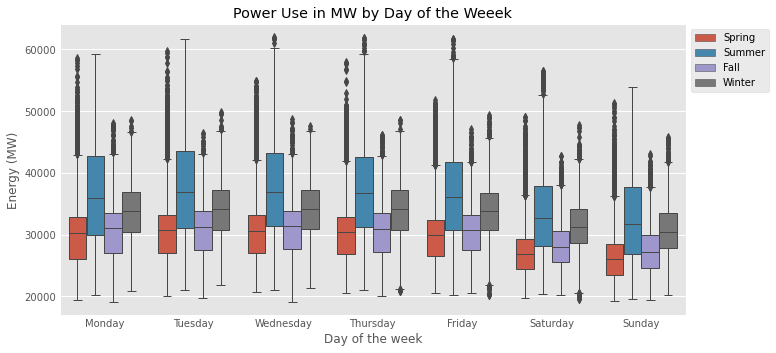

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
sn.boxplot(data=features_and_target.dropna(),
          x='Weekday',
          y='PJME_MW',
          hue='Season',
          ax=ax,
          linewidth=1)
ax.set_title('Power Use in MW by Day of the Weeek')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

#### Train / Test Split

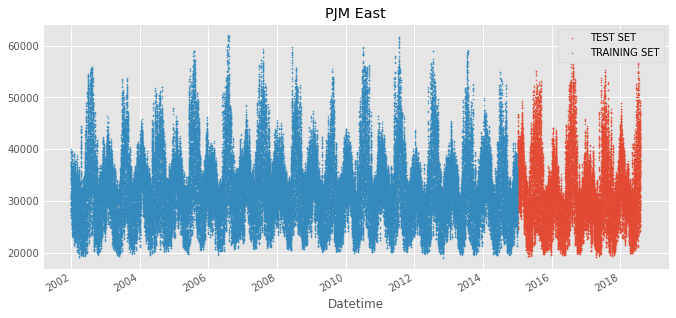

In [53]:
split_date = '1-Jan-2015'
energy_train = energy.loc[df.index <= split_date].copy()
energy_test = energy.loc[df.index > split_date].copy()

energy_test.rename(columns={'PJME_MW':'TEST SET'}) \
              .join(energy_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
                   how = 'outer') \
              .plot(figsize=(10,5), title='PJM East', style='.', ms=1)
plt.show()

### Simple Prophet Model
* Prophet model expects a dataset to be named in a specific way. We will rename our dataframe columns before feedinf it into the model.
* Datetime column named  ds
* Target : y

In [55]:
from prophet import Prophet
energy_trp = energy_train.reset_index() \
.rename(columns={'Datetime': 'ds', 
                'PJME_MW': 'y'})

In [56]:
%time
model = Prophet()
model.fit(energy_trp)

CPU times: total: 0 ns
Wall time: 0 ns


15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:57:44 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
#Predict on test set with  model
energy_tep = energy_test.reset_index() \
.rename(columns={'Datetime': 'ds', 
                'PJME_MW': 'y'})

pjme_test_fcst = model.predict(energy_tep)

In [58]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31207.157592,24279.989307,32782.408004,31207.157592,31207.157592,-2842.760656,-2842.760656,-2842.760656,-4428.701824,...,1279.927448,1279.927448,1279.927448,306.013720,306.013720,306.013720,0.0,0.0,0.0,28364.396936
1,2015-01-01 02:00:00,31207.119198,22299.484617,31389.990399,31207.119198,31207.119198,-4346.982903,-4346.982903,-4346.982903,-5925.556741,...,1271.265025,1271.265025,1271.265025,307.308813,307.308813,307.308813,0.0,0.0,0.0,26860.136295
2,2015-01-01 03:00:00,31207.080803,21481.455542,30450.160976,31207.080803,31207.080803,-5218.767550,-5218.767550,-5218.767550,-6788.813482,...,1261.400424,1261.400424,1261.400424,308.645509,308.645509,308.645509,0.0,0.0,0.0,25988.313254
3,2015-01-01 04:00:00,31207.042409,21580.369339,30580.368407,31207.042409,31207.042409,-5360.395500,-5360.395500,-5360.395500,-6920.874625,...,1250.455289,1250.455289,1250.455289,310.023836,310.023836,310.023836,0.0,0.0,0.0,25846.646909
4,2015-01-01 05:00:00,31207.004014,21797.789205,31069.660098,31207.004014,31207.004014,-4685.966388,-4685.966388,-4685.966388,-6235.973735,...,1238.563530,1238.563530,1238.563530,311.443817,311.443817,311.443817,0.0,0.0,0.0,26521.037626


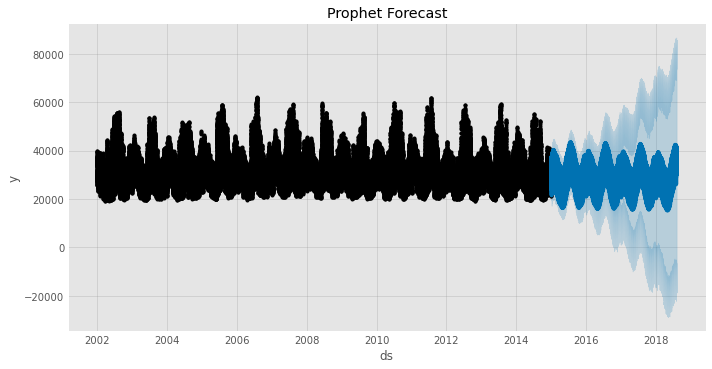

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()
# The plot in blue is the forecast for the future while the plots that are greyed out are the confidence intervals.
# The confidence intervals gives us the range beyond which the values are not meant to exceed.

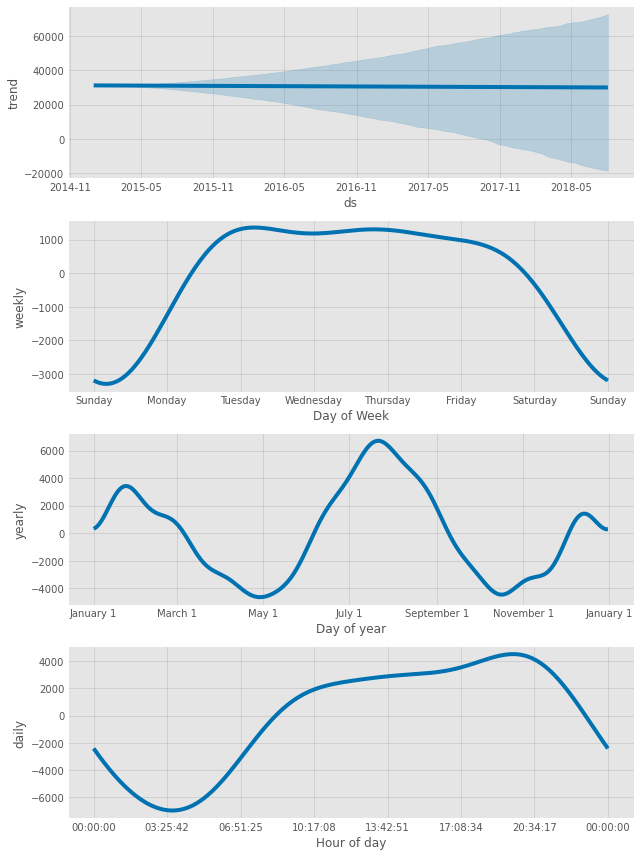

In [60]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

#### Forecast VS Actuals

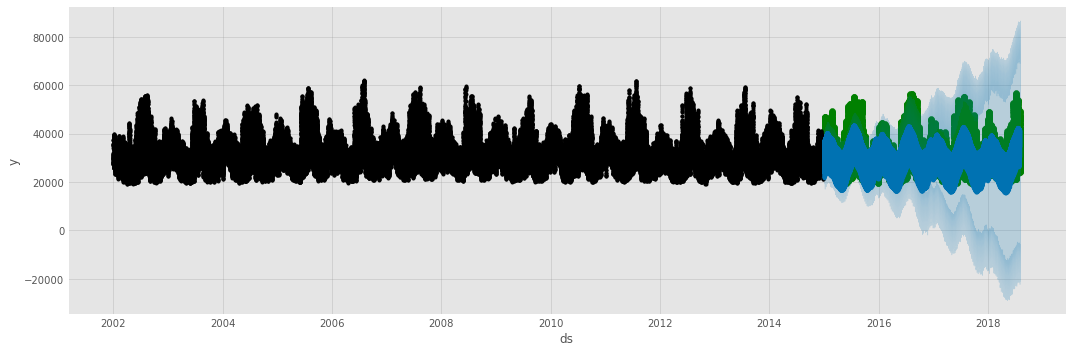

In [61]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(energy_test.index, energy_test['PJME_MW'], color = 'g')
fig = model.plot(pjme_test_fcst, ax=ax)

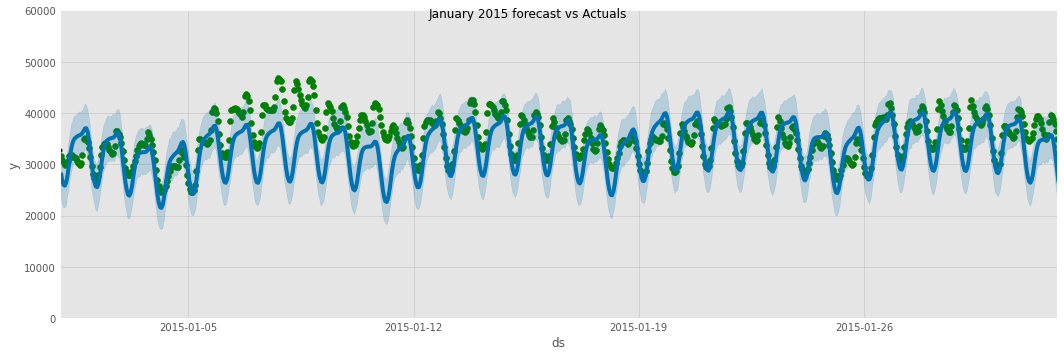

In [62]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(energy_test.index, energy_test['PJME_MW'], color = 'g')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower= '01-01-15',
             upper = '02-01-15')
ax.set_ylim(0,60000)
plot = plt.suptitle('January 2015 forecast vs Actuals')

#From the plot, we can see that early in the month, the actual values were higher than the predicted values.
# However, at the middle of the month, the predicted values became significantly closer to the actual values and 
#Then a further drift downwards from the actual values towards the end of the month.

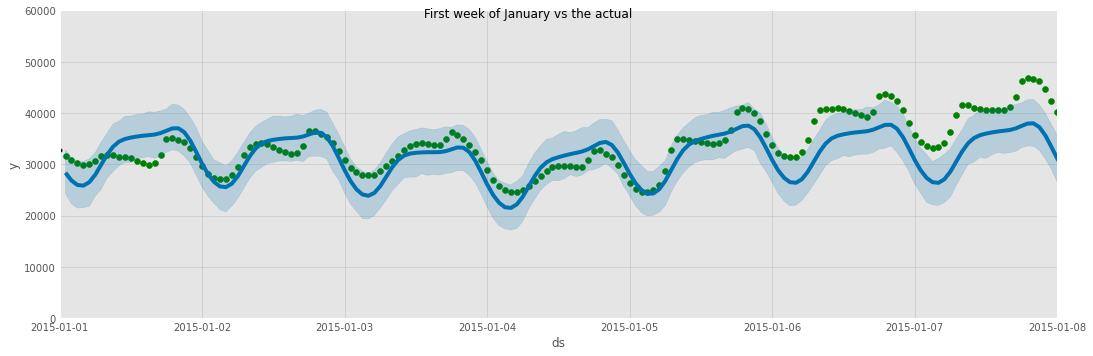

In [63]:
#Forecast for the first week of January vs the actual.
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(energy_test.index, energy_test['PJME_MW'], color = 'g')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower= '01-01-15',
             upper = '01-08-15')
ax.set_ylim(0,60000)
plot = plt.suptitle('First week of January vs the actual')

#From the plot, we can see that the predicted values closely follows the trend of the actual data.

In [ ]:
Evaluate the model using error metrics

In [64]:
np.sqrt(mean_squared_error(y_true=energy_test['PJME_MW'],
                          y_pred=pjme_test_fcst['yhat']))

6617.292584762368

In [65]:
mean_absolute_error(y_true=energy_test['PJME_MW'],
                          y_pred=pjme_test_fcst['yhat'])

5182.3497040828515

In [66]:
mean_absolute_percentage_error(y_true=energy_test['PJME_MW'],
                          y_pred=pjme_test_fcst['yhat'])

16.504513502548427

### Adding Holidays
We will use the Pandas USFedralHolidayCalendar to obtain the list of holidays.




In [67]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal= calendar()

holidays = cal.holidays(start=energy.index.min(),
                       end=energy.index.max(),
                       return_name = True)
holiday_df = pd.DataFrame(data=holidays, columns=['holiday_name']) \
.assign(holiday='USFederalHoliday')

In [68]:
holiday_df['holiday_name'].value_counts()

Birthday of Martin Luther King, Jr.    17
Washington’s Birthday                  17
Memorial Day                           17
Independence Day                       17
Labor Day                              16
Columbus Day                           16
Veterans Day                           16
Thanksgiving Day                       16
Christmas Day                          16
New Year's Day                         16
Name: holiday_name, dtype: int64

In [69]:
holiday_df = pd.DataFrame(data=holidays, columns=['holiday'])


In [70]:
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [72]:
hols_model = Prophet(holidays=holiday_df)
hols_model.fit(energy_tep)

16:08:03 - cmdstanpy - INFO - Chain [1] start processing
16:08:48 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
# Predict on training set with model
energy_hols_fcst = hols_model.predict(df=energy_tep)

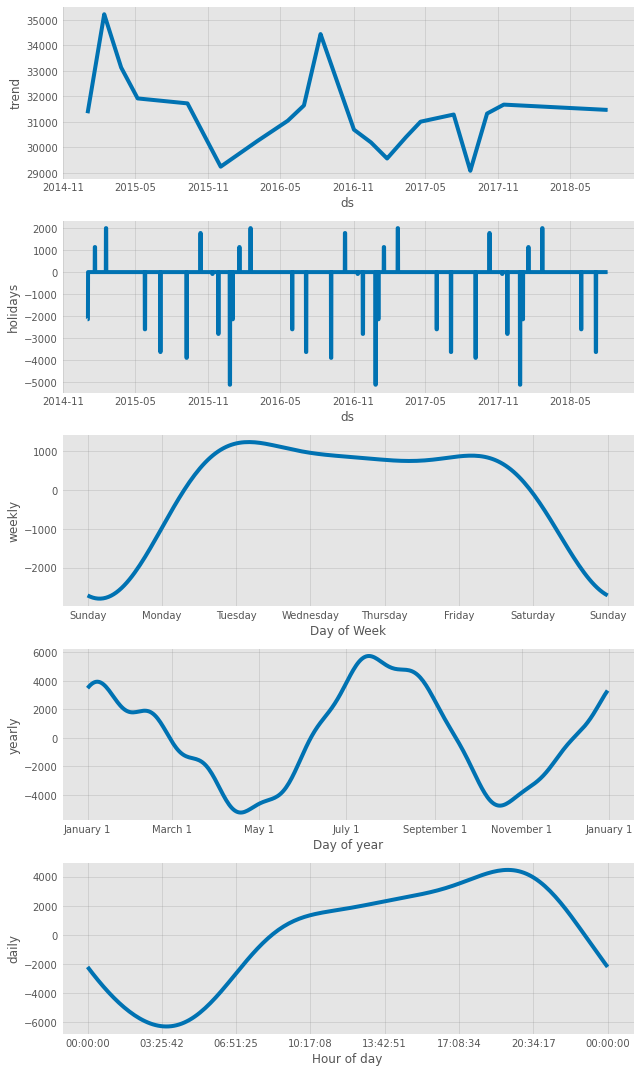

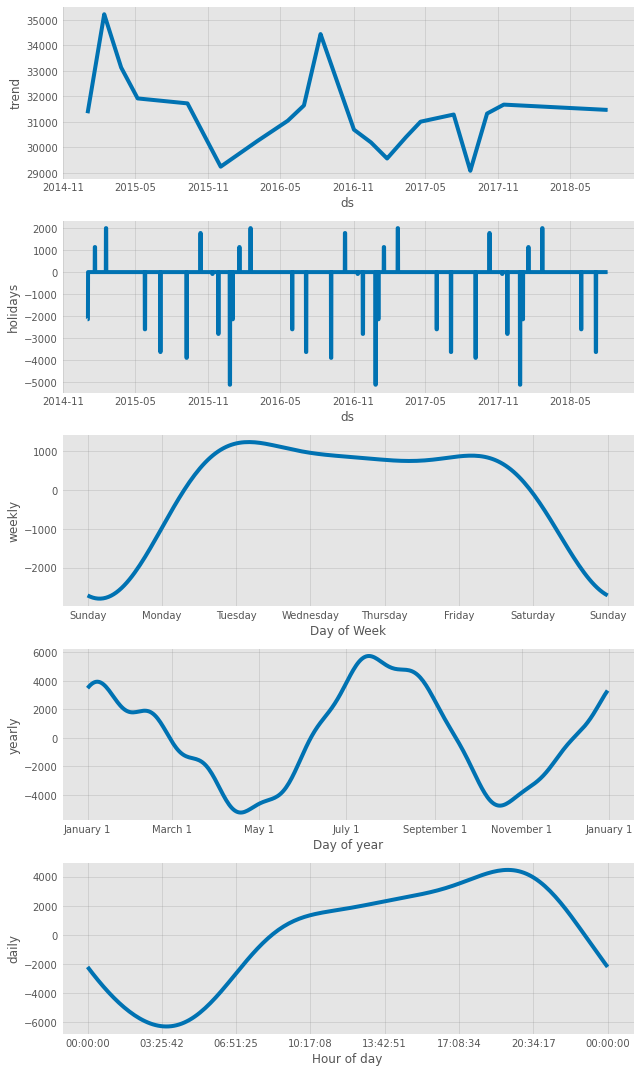

In [75]:
hols_model.plot_components(energy_hols_fcst)

In [76]:
energy_hols_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31334.609943,24529.657847,34142.236164,31334.609943,31334.609943,0.0,0.0,0.0,0.0,...,768.670957,768.670957,768.670957,3421.133005,3421.133005,3421.133005,0.0,0.0,0.0,29386.516234
1,2015-01-01 02:00:00,31338.470335,23095.227987,33368.500634,31338.470335,31338.470335,0.0,0.0,0.0,0.0,...,763.187383,763.187383,763.187383,3426.622877,3426.622877,3426.622877,0.0,0.0,0.0,28039.574076
2,2015-01-01 03:00:00,31342.330727,22685.518107,31840.937623,31342.330727,31342.330727,0.0,0.0,0.0,0.0,...,758.286797,758.286797,758.286797,3432.089827,3432.089827,3432.089827,0.0,0.0,0.0,27251.043873
3,2015-01-01 04:00:00,31346.191119,22412.632418,31752.565541,31346.191119,31346.191119,0.0,0.0,0.0,0.0,...,754.076235,754.076235,754.076235,3437.533713,3437.533713,3437.533713,0.0,0.0,0.0,27154.178250
4,2015-01-01 05:00:00,31350.051511,23147.041191,32747.752632,31350.051511,31350.051511,0.0,0.0,0.0,0.0,...,750.660134,750.660134,750.660134,3442.954393,3442.954393,3442.954393,0.0,0.0,0.0,27847.237803


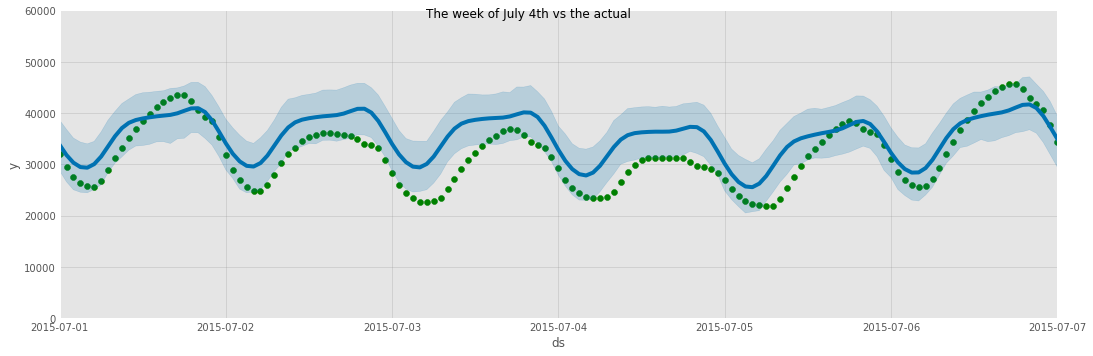

In [77]:
#Forecast for the first week of January vs the actual.
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(energy_test.index, energy_test['PJME_MW'], color = 'g')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower= '07-01-15',
             upper = '07-07-15')
ax.set_ylim(0,60000)
plot = plt.suptitle('The week of July 4th vs the actual')

# From the plot, we can see that the model performed slightly worse than the actual but the trend was followed.

In [79]:
np.sqrt(mean_squared_error(y_true=energy_test['PJME_MW'],
                          y_pred= energy_hols_fcst['yhat']))

6840.159056245628

In [80]:
mean_absolute_error(y_true=energy_test['PJME_MW'],
                          y_pred=energy_hols_fcst['yhat'])

5385.560438199317

In [81]:
mean_absolute_percentage_error(y_true=energy_test['PJME_MW'],
                          y_pred=energy_hols_fcst['yhat'])

17.390128452483715

In [ ]:
#We can see that the predictions are worse off. It probably predicted correctly on the days of the holidays.

### Predict into the future

In [83]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = hols_model.predict(future)

In [84]:
forecast['yhat']

0       29386.516234
1       28039.574076
2       27251.043873
3       27154.178250
4       27847.237803
            ...     
8755    38075.467636
8756    37243.725414
8757    35669.329714
8758    33655.521501
8759    29464.038118
Name: yhat, Length: 8760, dtype: float64

In [85]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31334.609943,24444.558501,34074.866976,31334.609943,31334.609943,0.0,0.0,0.0,0.0,...,768.670957,768.670957,768.670957,3421.133005,3421.133005,3421.133005,0.0,0.0,0.0,29386.516234
1,2015-01-01 02:00:00,31338.470335,23607.153700,32728.993324,31338.470335,31338.470335,0.0,0.0,0.0,0.0,...,763.187383,763.187383,763.187383,3426.622877,3426.622877,3426.622877,0.0,0.0,0.0,28039.574076
2,2015-01-01 03:00:00,31342.330727,22552.290189,31857.789191,31342.330727,31342.330727,0.0,0.0,0.0,0.0,...,758.286797,758.286797,758.286797,3432.089827,3432.089827,3432.089827,0.0,0.0,0.0,27251.043873
3,2015-01-01 04:00:00,31346.191119,22242.559283,32049.588387,31346.191119,31346.191119,0.0,0.0,0.0,0.0,...,754.076235,754.076235,754.076235,3437.533713,3437.533713,3437.533713,0.0,0.0,0.0,27154.178250
4,2015-01-01 05:00:00,31350.051511,23093.984277,32438.030921,31350.051511,31350.051511,0.0,0.0,0.0,0.0,...,750.660134,750.660134,750.660134,3442.954393,3442.954393,3442.954393,0.0,0.0,0.0,27847.237803
